## Create and Graph Product & Brand level Matrices (G1, G2, G3 & P, Q, R) from metadata 

In [1]:
import os
import pickle
import pandas as pd
import numpy as np
import scipy.sparse.csr as csr
import scipy.sparse as sparse
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from fuzzywuzzy import fuzz
import re
import matplotlib.pyplot as plt
import timeit

In [2]:
%matplotlib inline

In [3]:
def getG(dfMain,dfAux,field):
    l_row = []
    l_column = []
    for idx, row in dfAux.iterrows(): # Check if product is in BOTH dfAux AND dfMain 
        if idx in dfMain.index:     # If product has been excluded from dfMain (ie no brand), exclude it from dfAux for G matrix 
            i = dfMain.index.get_loc(idx)
            l = re.findall(r"'(.*?)'", dfAux.loc[idx][field])
            for x in l:
                if x in dfMain.index:
                    if (i>dfMain.index.get_loc(x)):
                        l_row.append(i)
                        l_column.append(dfMain.index.get_loc(x))
    data = np.ones(len(l_row))
    return sparse.csr_matrix((data,(l_row,l_column)),shape=(dfMain.shape[0],dfMain.shape[0]))

#### Function to create dictionaries of each review type (Total, Positive, Negative) for each year & pass the output to 'createAlsoReviewed_2'

In [4]:
def createAlsoReviewed(dfMain,dfAux):
    bag_reviewers = {}
    bag_reviewers_pos={}
    bag_reviewers_neg={}
    for year in list(set(dfAux.Year)):
    #for year in [2014]: 
        bag_reviewers[year] = (createAlsoReviewed_1(dfMain,dfAux[dfAux.Year==year])) #create reviewers dictionary
        bag_reviewers_pos[year] = (createAlsoReviewed_1(dfMain,dfAux[(dfAux.rating>3) & (dfAux.Year==year)])) #create reviewers dictionary
        bag_reviewers_neg[year] = (createAlsoReviewed_1(dfMain,dfAux[(dfAux.rating<3) & (dfAux.Year==year)])) #create reviewers dictionary
    return createAlsoReviewed_2(dfAux,bag_reviewers,bag_reviewers_pos,bag_reviewers_neg)

#### Function to check which products have reviewed by each individual Reviewer 

In [5]:
def createAlsoReviewed_1(dfMain,dfAux):
    dic = {}
    for rev in set(dfAux['reviewerid']):
        r = dfAux[dfAux.reviewerid == rev].productid.tolist()
        if rev not in dic:
            dic[rev]=r
    return dic

In [6]:
def createAlsoReviewed_2(dfAux,reviewers,reviewers_p,reviewers_n): 
    l_rev = []
    l_rev_cont = []
    for i in range (0,len(dfAux)): #for each product
        l_aux = []
        rev = dfAux['reviewerid'].iloc[i]
        year = dfAux['Year'].iloc[i]
        rating = dfAux['rating'].iloc[i]
        if rev in reviewers.get(year):
            l_aux = reviewers[year][rev].copy()
            l_aux.remove(dfAux['productid'].iloc[i])
            l_rev.append(set(l_aux))
        if rating > 3 and rev in reviewers_n.get(year):
            contrarian = reviewers_n[year].copy()
        elif rating < 3 and rev in reviewers_p.get(year):
            contrarian = reviewers_p[year].copy()
        else:
            contrarian = []
        if rev in contrarian:
            l_aux = contrarian[rev].copy()
            l_rev_cont.append(set(l_aux))
        else:
            l_rev_cont.append([])
    targetDF = dfAux.copy()
    targetDF['also_reviewed'] = l_rev
    targetDF['also_reviewed_Contrarian'] = l_rev_cont
    return targetDF

In [7]:
def getP(dfMain,dfAux):
    l_row = [] 
    l_column = []
    l_data = []
    dic = {}
    for idx, row in dfAux.iterrows(): #for each product in the review dataset
        idxMain =  row['productid'] 
        i = dfMain.index.get_loc(idxMain) #index of the product in the Main DataFrame
        #l = re.findall(r"'(.*?)'", dfAux.loc[idx]['also_reviewed_by']) #list of products also reviewed by the valid reviewer
        l = dfAux.loc[idx]['also_reviewed']
        for x in l: #for each element that was also reviewed
            if x in dfMain.index:
                j = dfMain.index.get_loc(x)
                if (i > j):
                    pair = ((i,j))
                    if pair in dic: 
                        l_data[dic[pair]]=l_data[dic[pair]]+1; 
                        #print(l_data[l_column.index(j)],pair)
                    else:
                        l_row.append(i)
                        l_column.append(j)
                        l_data.append(1)
                        dic[pair]=len(l_row)-1
    return dic,sparse.csr_matrix((l_data,(l_row,l_column)),shape=(dfMain.shape[0],dfMain.shape[0]),dtype=np.int16)

In [8]:
def getQR(dfMain,dfAux):
    l_row_Q = []
    l_column_Q = []
    l_data_Q = []
    l_row_R = []
    l_column_R = []
    l_data_R = []
    dic_Q = {}
    dic_R = {}
    for idx, row in dfAux.iterrows(): #for each product in the review dataset
        idxMain =  row['productid']
        rating = row['rating']
        i = dfMain.index.get_loc(idxMain) #index of the product in the Main DataFrame
        l = dfAux.loc[idx]['also_reviewed_Contrarian']
        for x in l: #for each element that was also reviewed
            if x in dfMain.index:
                j = dfMain.index.get_loc(x)
                pair = ((i,j))
                if rating > 3:
                    if pair in dic_Q:
                        l_data_Q[dic_Q[pair]]=l_data_Q[dic_Q[pair]]+1;
                    else:
                        l_row_Q.append(i)
                        l_column_Q.append(j)
                        l_data_Q.append(1)
                        dic_Q[pair]=len(l_row_Q)-1
                #print(l_data[l_column.index(j)],pair)
                if rating < 3:
                    if pair in dic_R:
                        l_data_R[dic_R[pair]]=l_data_R[dic_R[pair]]+1;
                    else:
                        l_row_R.append(i)
                        l_column_R.append(j)
                        l_data_R.append(1)
                        dic_R[pair]=len(l_row_R)-1
    Q=sparse.csr_matrix((l_data_Q,(l_row_Q,l_column_Q)),shape=(dfMain.shape[0],dfMain.shape[0]),dtype=np.int16)
    R=sparse.csr_matrix((l_data_R,(l_row_R,l_column_R)),shape=(dfMain.shape[0],dfMain.shape[0]),dtype=np.int16)
    return dic_Q,dic_R,Q,R

In [9]:
def createPQR(dfDepartment, dfDepartment_Also_Bought, dfDepartment_Also_Viewed, dfDepartment_Reviews):
    dfDepartment_Reviews['Year'] = pd.to_datetime(dfDepartment_Reviews['timestamp']).map(lambda x: x.year)
    control = dfDepartment_Reviews.groupby(['Year','productid']).size() #diagonal value per year
    df_diag = pd.DataFrame(0, index=dfDepartment.index, columns=sorted(control.index.get_level_values('Year').unique()))
    years=sorted(control.index.get_level_values('Year').unique())
    for year in years:
        for pid in control[year].index:
            cidx=  dfDepartment.index.get_loc(pid)
            df_diag.loc[pid][year] = control[year,pid]/2
            #print(control[year,pid])
    dfFullReviews = createAlsoReviewed(dfDepartment,dfDepartment_Reviews) 
    # Create dictionaries to hold indiv. P, Q & R matrices: {KEY = 'Year XXXX': VALUE = 'P, Q or R matrix for given 'Year XXXX'}
    bag_P = {}
    bag_Q = {}
    bag_R = {}
    for year in [2014]:   # specify particular year (2014) to calculate PQR for the last year worth of data (per instructions)
    #for year in sorted(dfDepartment_Reviews.Year.unique()):
        _,temp = getP(dfDepartment,dfFullReviews[dfFullReviews.Year==year])
        _,_,temp_Q,temp_R = getQR(dfDepartment,dfFullReviews[dfFullReviews.Year==year])
        temp = temp.tolil()
        temp.setdiag(df_diag[year].values)
        bag_P[year] = temp
        bag_Q[year] = temp_Q
        bag_R[year] = temp_R
    return bag_P,bag_Q,bag_R, years,df_diag

In [10]:
if 0:
    df_diag = pd.DataFrame(0, index=dfCell.index, columns=sorted(control.index.get_level_values('Year').unique()))
    years=sorted(control.index.get_level_values('Year').unique())
    for year in years:
        for pid in control[year].index:
            cidx=  dfCell.index.get_loc(pid)
            df_diag.loc[pid][year] = control[year,pid]/2

In [11]:
if 0:
    bag_P = {}
    bag_Q = {}
    bag_R = {}
    for year in [2014]:
        _,temp = getP(dfCell,dfFullReviews[dfFullReviews.Year==year])
        _,_,temp_Q,temp_R = getQR(dfCell,dfFullReviews[dfFullReviews.Year==year])
        temp = temp.tolil()
        temp.setdiag(df_diag[year].values)
        bag_P[year] = temp
        bag_Q[year] = temp_Q
        bag_R[year] = temp_R

### Access product data directly from the shared drive

In [12]:
filepath = r'C:\Users\David\Google Drive (deh284@nyu.edu)\datasets\amazon\processed'

In [13]:
cols = ['productid','title','brand']
dfBeauty = pd.read_csv(filepath + r'\Beauty\df_products_Beauty.csv',usecols=cols,index_col='productid')
dfCell = pd.read_csv(filepath + r'\CellphoneAndAccessories\df_products_Cell.csv',usecols=cols,index_col='productid')
dfElect = pd.read_csv(filepath + r'\Electronics\df_products_Elec.csv',usecols=cols,index_col='productid')

In [14]:
dfBeauty.head()

title brand
productid                                                          
0205616461  Bio-Active Anti-Aging Serum (Firming Ultra-Hyd...   NaN
0558925278  Eco Friendly Ecotools Quality Natural Bamboo C...   NaN
0733001998                                Mastiha Body Lotion   NaN
0737104473  Hello Kitty Lustre Lipstick (See sellers comme...   NaN
0762451459        Stephanie Johnson Mermaid Round Snap Mirror   NaN

In [15]:
print(dfBeauty.shape)
print(dfCell.shape)
print(dfElect.shape)

(259204, 2)
(346793, 2)
(498196, 2)


In [16]:
#column 'also bought' contains a string with format [item1, item2, ..., itemN]
dfB_AB = pd.read_csv(filepath + r'\Beauty\df_products_also_bought_Beauty.csv',index_col='productid') 
dfC_AB = pd.read_csv(filepath + r'\CellphoneAndAccessories\df_products_also_bought_Cell.csv',index_col='productid') 
dfE_AB = pd.read_csv(filepath + r'\Electronics\df_products_also_bought_Elec.csv',index_col='productid') 

In [17]:
dfB_AB.head()

also_bought
productid                                                    
1304146537                       ['B002J2KOXK', 'B008TCVZ6Y']
130414643X  ['B002J2KOXK', 'B005CYJII4', 'B008TCVZ6Y', 'B0...
1304196135  ['B001GNBVU8', 'B002MEWGDG', 'B00CHLSN3Q', 'B0...
1304139220                                     ['B006RRY4NE']
1304196070                                     ['B00CHLSN3Q']

In [18]:
# also_viewed data
dfB_AV = pd.read_csv(filepath + r'\Beauty\df_products_also_viewed_Beauty.csv',index_col='productid') 
dfC_AV = pd.read_csv(filepath + r'\CellphoneAndAccessories\df_products_also_viewed_Cell.csv',index_col='productid') 
dfE_AV = pd.read_csv(filepath + r'\Electronics\df_products_also_viewed_Elec.csv',index_col='productid') 

In [19]:
# review data
dfB_Review = pd.read_csv(filepath + r'\Beauty\df_reviews_Beauty.csv',index_col=0)
dfC_Review = pd.read_csv(filepath + r'\CellphoneAndAccessories\df_reviews_Cell.csv',index_col=0)
#dfE_Review = pd.read_csv(filepath + r'\Electronics\df_reviews_Elec.csv',index_col=0)
dfE_Review = pd.read_pickle(filepath + r'\Electronics\df_reviews_Elec.pkl') # Load pickle file for Electronics due to size of csv

In [20]:
dfC_Review.head()

timestamp   productid      reviewerid  rating  \
0  2014-05-21  120401325X  A30TL5EWN6DFXT     4.0   
1  2014-01-14  120401325X   ASY55RVNIL0UD     5.0   
2  2014-06-26  120401325X  A2TMXE2AFO7ONB     5.0   
3  2013-10-21  120401325X   AWJ0WZQYMYFQ4     4.0   
4  2013-02-03  120401325X   ATX7CZYFXI1KW     5.0   

                                         review_text  \
0  They look good and stick good! I just don't li...   
1  These stickers work like the review says they ...   
2  These are awesome and make my phone look so st...   
3  Item arrived in great time and was in perfect ...   
4  awesome! stays on, and looks great. can be use...   

                              review_summary  
0                                 Looks Good  
1                      Really great product.  
2                             LOVE LOVE LOVE  
3                                      Cute!  
4  leopard home button sticker for iphone 4s

In [21]:
dfE_Review.head()

timestamp   productid      reviewerid  rating  \
0 2013-06-02  0528881469   AO94DHGC771SJ     5.0   
1 2010-11-25  0528881469   AMO214LNFCEI4     1.0   
2 2010-09-09  0528881469  A3N7T0DY83Y4IG     3.0   
3 2010-11-24  0528881469  A1H8PY3QHMQQA0     2.0   
4 2011-09-29  0528881469  A24EV6RXELQZ63     1.0   

                                         review_text  \
0  We got this GPS for my husband who is an (OTR)...   
1  I'm a professional OTR truck driver, and I bou...   
2  Well, what can I say.  I've had this unit in m...   
3  Not going to write a long review, even thought...   
4  I've had mine for a year and here's what we go...   

                           review_summary  
0                         Gotta have GPS!  
1                       Very Disappointed  
2                          1st impression  
3                 Great grafics, POOR GPS  
4  Major issues, only excuses for support

### Aggregate over various products in a given "brand" (the "brand" feature is in the product metadata)

#### Remove product instances from each group that DO NOT HAVE a designated brand

In [22]:
if 0:
    dfBeauty = dfBeauty[~dfBeauty['brand'].isnull()]
    dfCell = dfCell[~dfCell['brand'].isnull()]
    dfElect = dfElect[~dfElect['brand'].isnull()]

#### ALTERNATIVE METHOD: Use function to remove product IDs where brand = null type/'Unknown'. Remove apostrophes ('), clean ampersands

In [23]:
def cleanBrands(df):
    df = df[~df['brand'].isnull()]
    df = df[~(df['brand'] == 'Unknown')]
    df['brand'] = df['brand'].str.replace('&#39;','')
    df['brand'] = df['brand'].str.replace('&amp;','&')
    
    return df 

#### Brand-level preprocessing (Part 1): Apply function to 'clean' brand metadata for all three product types

In [24]:
dfBeauty = cleanBrands(dfBeauty)
dfCell = cleanBrands(dfCell)
dfElect = cleanBrands(dfElect)

In [25]:
print(dfBeauty.shape)
print(dfCell.shape)
print(dfElect.shape)

(126619, 2)
(77835, 2)
(137968, 2)


#### Function to screen & match Product IDs with brand name similarities (FuzzyWuzzy), then remove seldom-used brand names (< 3 instances) 

In [26]:
def matchBrands(df):
    df = df.copy()
    brand_size = df.groupby('brand').size()
    brand_small = brand_size.index[brand_size <= 3]   # define groups of brand names with 3 instances or less
    brand_mult = brand_size.index[brand_size > 3]     # define droups of brand names with more than 3 instances
    #results = []
    for brand in brand_small:               # iterate through brand names with 3 instances or less
        scores = []                         # compare less frequent brand names to those with more than 3 instances: 
        for match in brand_mult:                                   # comparison method is FuzzyWuzzy's Simple Ratio
            scores.append((match, fuzz.ratio(brand, match)))       # (Pure Levenshtein Distance based matching)
        scores = sorted(scores, key=lambda x: x[1], reverse=True)
        if scores[0][1] >= 87:                                     # retain brand matches scoring 87 or above (0-100 scale)
            df.loc[df['brand'] == brand, 'brand'] = scores[0][0]
        #results.append((brand,scores[0][0],scores[0][1]))
   
    brand_size = df.groupby('brand').size()                 # at conclusion of the matching process, 
    valid_brands = brand_size.index[brand_size >= 3]        # remove all remaining brand names with only 1 or 2 instances 
    df = df[df['brand'].isin(valid_brands)]
    
    return df

In [27]:
if 0:
    brand_size = dfBeauty.groupby('brand').size()
    brand_small = brand_size.index[brand_size <= 3]
    brand_mult = brand_size.index[brand_size > 3]

#### Brand-level preprocessing (Part 2): Apply function to 'match' & filter remaining brand metadata for all 3 product types (up to ~10 min run time)

In [28]:
start_time = timeit.default_timer()

dfBeauty = matchBrands(dfBeauty)
dfCell = matchBrands(dfCell)
dfElect = matchBrands(dfElect)

print('{0:.2f} seconds'.format(timeit.default_timer() - start_time))

532.96 seconds


#### Save respective product dataframes to pickle for future retrieval (equity model) following Brand-level preprocessing

In [99]:
dfBeauty.to_pickle(os.getcwd() + r'\pickle\dfBeauty.pkl')
dfCell.to_pickle(os.getcwd() + r'\pickle\dfCell.pkl')
dfElect.to_pickle(os.getcwd() + r'\pickle\dfElect.pkl')

In [29]:
print(dfBeauty.shape)
print(dfCell.shape)
print(dfElect.shape)

(116903, 2)
(74296, 2)
(130899, 2)


#### Most frequently occuring brand names

In [30]:
dfBeauty.groupby('brand').size().sort_values(ascending = False).head(10)

brand
LOreal Paris         1985
OPI                  1966
Revlon               1418
Bath & Body Works    1326
Maybelline           1189
Essie                 901
COVERGIRL             874
M.A.C                 870
Victorias Secret      851
Clinique              808
dtype: int64

#### Percentiles for how many times individual brand names occur (~17% of brand names are associated with 3 Product IDs)  

In [31]:
(dfElect.groupby('brand').size().sort_values(ascending = False).reset_index().groupby(0).size().\
        sort_values(ascending = False)/len(dfElect['brand'].unique())).head()

0
3    0.176745
4    0.114798
5    0.080629
6    0.058751
7    0.056539
dtype: float64

#### Show size of pre-screened 'also bought' matrices

In [32]:
print(dfB_AB.shape)
print(dfC_AB.shape)
print(dfE_AB.shape)

(126419, 1)
(123385, 1)
(141780, 1)


#### Eliminate product rows in 'also bought' which do not correspond to original product data with defined brands (speeds calculation time)

In [33]:
dfB_AB = dfB_AB[dfB_AB.index.isin(dfBeauty.index)]
dfC_AB = dfC_AB[dfC_AB.index.isin(dfCell.index)]
dfE_AB = dfE_AB[dfE_AB.index.isin(dfElect.index)]

In [34]:
print(dfB_AB.shape)
print(dfC_AB.shape)
print(dfE_AB.shape)

(78081, 1)
(40821, 1)
(63096, 1)


#### Eliminate product rows in 'also viewed' which do not correspond to original product data with defined brands (speeds calculation time)

In [35]:
dfB_AV = dfB_AV[dfB_AV.index.isin(dfBeauty.index)]
dfC_AV = dfC_AV[dfC_AV.index.isin(dfCell.index)]
dfE_AV = dfE_AV[dfE_AV.index.isin(dfElect.index)]

In [36]:
print(dfB_AV.shape)
print(dfC_AV.shape)
print(dfE_AV.shape)

(110237, 1)
(19490, 1)
(53529, 1)


#### Eliminate product rows in "review" which do not correspond to original product data with defined brands (speeds calculation time)

In [37]:
dfB_Review = dfB_Review[dfB_Review['productid'].isin(dfBeauty.index)]
dfC_Review = dfC_Review[dfC_Review['productid'].isin(dfCell.index)]
dfE_Review = dfE_Review[dfE_Review['productid'].isin(dfElect.index)]

In [38]:
print(dfB_Review.shape)
print(dfC_Review.shape)
print(dfE_Review.shape)

(160636, 6)
(97122, 6)
(920955, 6)


### Construction of G1 (products in 'also_bought')

In [39]:
# Construct G1 Matrices for each product group:
B_G1 = getG(dfBeauty,dfB_AB,'also_bought')
C_G1 = getG(dfCell,dfC_AB,'also_bought')
E_G1 = getG(dfElect,dfE_AB,'also_bought')

#### Add each G1 matrix with its transpose to ensure it is a full matrix (and not lower triangular)

In [40]:
B_G1 = B_G1.T + B_G1
C_G1 = C_G1.T + C_G1
E_G1 = E_G1.T + E_G1

In [41]:
B_G1.sum()
B_G1

<116903x116903 sparse matrix of type '<class 'numpy.float64'>'
	with 1317014 stored elements in Compressed Sparse Column format>

#### Function to create a sparse transformation matrix that converts "product:product" relationship to "brand:brand"

In [42]:
def prod2brand(df):
    row = []
    col = []
    brands = df['brand'].unique().tolist()   # Create list of all individual brands
    
    for prod in range(df.shape[0]):                # Iterate over all rows in product dataframe
        row.append(prod)                           # Add row for each individual product
        col.append(brands.index(df.iloc[prod,1]))  # Find related brand (column 1 -> see below) and append its index value
        
    data = [1]*len(row)                            # Define the amount of data (# of rows/products * 1 brand each)
    return sparse.csr_matrix((data,(row,col)),shape=(df.shape[0],len(brands))) # return n x m (products x brands) sparse matrix 

In [43]:
dfBeauty.head()

title       brand
productid                                                                
1304196135  Max Factor Lasting Performance Foundation -106...  Max Factor
1304139220                 MAC Lip Care - Lip Pencil - Auburn       M.A.C
1304351475  NEW EUROPEAN COLLECTION Too Faced Natural Eyes...    Omagazee
1572671203  Perlage Fortifying Rejuvenation Treatment Refi...     Perlage
1906987238  Tonymoly Intense Care Snail Hydro-gel Mask 10 Pcs    TONYMOLY

#### Construct Transformation Matrix for each product group

In [44]:
B_Transform = prod2brand(dfBeauty)
C_Transform = prod2brand(dfCell)
E_Transform = prod2brand(dfElect)

In [45]:
print(B_Transform.shape)
print(C_Transform.shape)
print(E_Transform.shape)

(116903, 4901)
(74296, 1785)
(130899, 4068)


### Build 'Brand' G1 Matrices

#### 'Beauty' example: take dot products of the transpose of the transform matrix, 'Product'-level G1 & the transform matrix again: 
### $B_{trans}^T \bullet B_{G1} \bullet B_{trans}$ 

In [46]:
B_G1_Brand = B_Transform.transpose().dot(B_G1).dot(B_Transform)
B_G1_Brand[B_G1_Brand > 0] = 1    # Change every brand index number to 1 so 'brand' G1 is a sparse matrix of 0s & 1s 

C_G1_Brand = C_Transform.transpose().dot(C_G1).dot(C_Transform)
C_G1_Brand[C_G1_Brand > 0] = 1    # Change every brand index number to 1 so 'brand' G1 is a sparse matrix of 0s & 1s

E_G1_Brand = E_Transform.transpose().dot(E_G1).dot(E_Transform)
E_G1_Brand[E_G1_Brand > 0] = 1    # Change every brand index number to 1 so 'brand' G1 is a sparse matrix of 0s & 1s

#### Verify 'Brand' G1 Matrix sizes

In [47]:
print(B_G1_Brand.shape)
print(C_G1_Brand.shape)
print(E_G1_Brand.shape)

(4901, 4901)
(1785, 1785)
(4068, 4068)


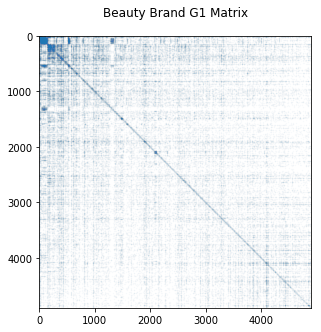

In [48]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.spy(B_G1_Brand, ms=0.01)
ax.xaxis.tick_bottom()
plt.title('Beauty Brand G1 Matrix')
plt.show()

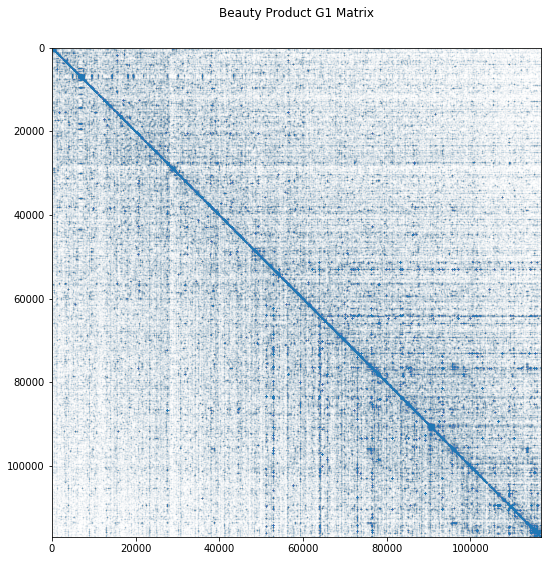

In [49]:
fig, ax = plt.subplots(figsize=(9, 9))
ax.spy(B_G1, ms=0.01)
ax.xaxis.tick_bottom()
plt.title('Beauty Product G1 Matrix')
plt.show()

In [50]:
C_G1.shape

(74296, 74296)

### Construction of G2 (products in 'also_viewed')

In [51]:
start_time = timeit.default_timer()

# Construct G2 Matrices for each product group:
B_G2 = getG(dfBeauty,dfB_AV,'also_viewed')
C_G2 = getG(dfCell,dfC_AV,'also_viewed')
E_G2 = getG(dfElect,dfE_AV,'also_viewed')

print('{0:.2f} seconds'.format(timeit.default_timer() - start_time))

72.04 seconds


#### Add each G1 matrix with its transpose to ensure it is a full matrix (and not lower triangular)

In [52]:
B_G2 = B_G2.T + B_G2
C_G2 = C_G2.T + C_G2
E_G2 = E_G2.T + E_G2

### Build 'Brand' G2 Matrices

### $B_{trans}^T \bullet B_{G2} \bullet B_{trans}$ 

In [53]:
B_G2_Brand = B_Transform.transpose().dot(B_G2).dot(B_Transform)
B_G2_Brand[B_G2_Brand > 0] = 1    # Change every brand index number to 1 so 'brand' G2 is a sparse matrix of 0s & 1s 

C_G2_Brand = C_Transform.transpose().dot(C_G2).dot(C_Transform)
C_G2_Brand[C_G2_Brand > 0] = 1    # Change every brand index number to 1 so 'brand' G2 is a sparse matrix of 0s & 1s

E_G2_Brand = E_Transform.transpose().dot(E_G2).dot(E_Transform)
E_G2_Brand[E_G2_Brand > 0] = 1    # Change every brand index number to 1 so 'brand' G2 is a sparse matrix of 0s & 1s

#### Verify 'Brand' G2 Matrix sizes

In [54]:
print(B_G2_Brand.shape)
print(C_G2_Brand.shape)
print(E_G2_Brand.shape)

(4901, 4901)
(1785, 1785)
(4068, 4068)


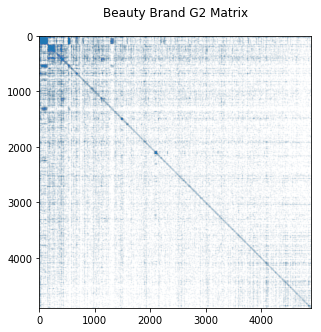

In [55]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.spy(B_G2_Brand, ms=0.01)
ax.xaxis.tick_bottom()
plt.title('Beauty Brand G2 Matrix')
plt.show()

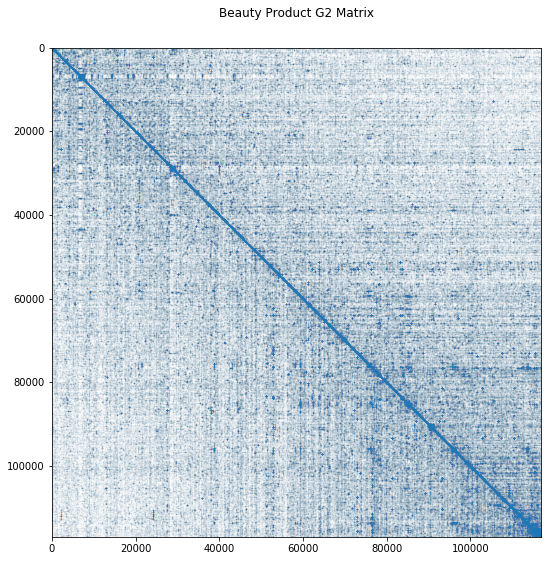

In [56]:
fig, ax = plt.subplots(figsize=(9, 9))
ax.spy(B_G2, ms=0.01)
ax.xaxis.tick_bottom()
plt.title('Beauty Product G2 Matrix')
plt.show()

### Construction of G3 (those who are in 'also_viewed' but not in 'also_bought')

In [57]:
# Construct G3 Matrices for each product group:
B_G3 = (B_G2 - B_G1)
B_G3[B_G3 == -1] = 0

C_G3 = (C_G2 - C_G1)
C_G3[C_G3==-1] = 0

E_G3 = (E_G2 - E_G1)
E_G3[E_G3==-1] = 0

### Build 'Brand' G3 Matrices

### $B_{trans}^T \bullet B_{G3} \bullet B_{trans}$ 

In [58]:
B_G3_Brand = B_Transform.transpose().dot(B_G3).dot(B_Transform)
B_G3_Brand[B_G3_Brand > 0] = 1    # Change every brand index number to 1 so 'brand' G2 is a sparse matrix of 0s & 1s 

C_G3_Brand = C_Transform.transpose().dot(C_G3).dot(C_Transform)
C_G3_Brand[C_G3_Brand > 0] = 1    # Change every brand index number to 1 so 'brand' G2 is a sparse matrix of 0s & 1s

E_G3_Brand = E_Transform.transpose().dot(E_G3).dot(E_Transform)
E_G3_Brand[E_G3_Brand > 0] = 1    # Change every brand index number to 1 so 'brand' G2 is a sparse matrix of 0s & 1s

#### Verify 'Brand' G3 Matrix sizes

In [59]:
print(B_G3_Brand.shape)
print(C_G3_Brand.shape)
print(E_G3_Brand.shape)

(4901, 4901)
(1785, 1785)
(4068, 4068)


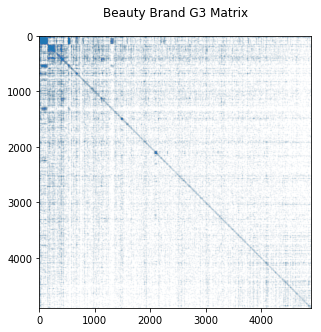

In [60]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.spy(B_G3_Brand, ms=0.01)
ax.xaxis.tick_bottom()
plt.title('Beauty Brand G3 Matrix')
plt.show()

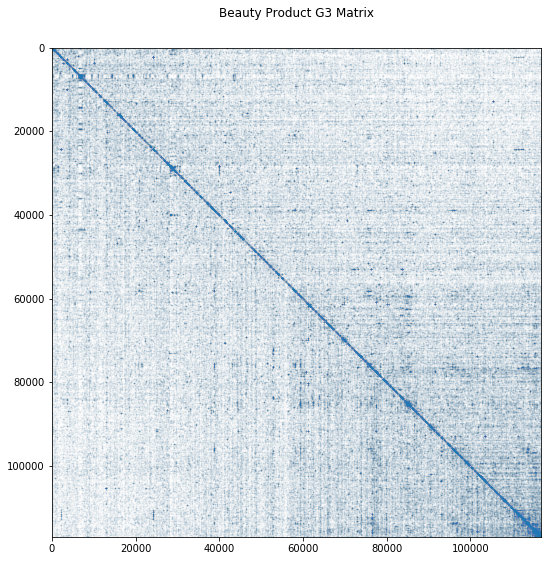

In [61]:
fig, ax = plt.subplots(figsize=(9, 9))
ax.spy(B_G3, ms=0.01)
ax.xaxis.tick_bottom()
plt.title('Beauty Product G3 Matrix')
plt.show()

### NOTE: All 3 'Brand' G Matrices for each product type should have the same size (Nbrands x Nbrands): 

In [62]:
print(B_G1_Brand.shape == B_G2_Brand.shape == B_G3_Brand.shape)
print(C_G1_Brand.shape == C_G2_Brand.shape == C_G3_Brand.shape)
print(E_G1_Brand.shape == E_G2_Brand.shape == E_G3_Brand.shape)

True
True
True


#### Define function to save/load pickle files for BRAND-LEVEL G1, G2, G3

In [63]:
def save_G_pickle(G1, G2, G3, tag):
    path = os.getcwd() + r'\pickle\\'
    pickle.dump(G1, open(path + tag + '_G1_Brand.pkl', "wb" ))
    pickle.dump(G2, open(path + tag + '_G2_Brand.pkl', "wb" ))
    pickle.dump(G3, open(path + tag + '_G3_Brand.pkl', "wb" ))

def load_G_pickle(tag):
    path = os.getcwd() + r'\pickle\\'
    return pickle.load(open(path + tag + '_G1_Brand.pkl', "rb" )), \
           pickle.load(open(path + tag + '_G2_Brand.pkl', "rb" )), \
           pickle.load(open(path + tag + '_G3_Brand.pkl', "rb" ))

### Save BRAND-LEVEL G1, G2, G3 Matrices for all product types

In [64]:
save_G_pickle(B_G1_Brand, B_G2_Brand, B_G3_Brand, 'B')
save_G_pickle(C_G1_Brand, C_G2_Brand, C_G3_Brand, 'C')
save_G_pickle(E_G1_Brand, E_G2_Brand, E_G3_Brand, 'E')

### Generate P, Q & R Matrices

#### Beauty PQR

In [65]:
start_time = timeit.default_timer()

#B_bag_P, B_bag_Q, B_bag_R, B_years, B_df_diag = createPQR(dfBeauty, dfB_AB, dfB_AV, dfB_Review)

print('{0:.2f} seconds'.format(timeit.default_timer() - start_time))

0.00 seconds


#### Cellphone & Accessories PQR 

In [66]:
start_time = timeit.default_timer()

#C_bag_P, C_bag_Q, C_bag_R, C_years, C_df_diag = createPQR(dfCell, dfC_AB, dfC_AV, dfC_Review)

print('{0:.2f} seconds'.format(timeit.default_timer() - start_time))

0.00 seconds


#### Electronics PQR

In [67]:
start_time = timeit.default_timer()

#E_bag_P, E_bag_Q, E_bag_R, E_years, E_df_diag = createPQR(dfElect, dfE_AB, dfE_AV, dfE_Review)

print('{0:.2f} seconds'.format(timeit.default_timer() - start_time))

0.00 seconds


#### PQR Matrices: Load respective pickle files and assign relevant content to be E_bag_P, E_bag_Q & E_bag_R

In [68]:
if 0:
    path = os.getcwd() + r'\pickle'

    E_bag_P = pickle.load(open(path + r'\P_Elec.pkl', "rb" ))
    E_bag_Q = pickle.load(open(path + r'\Q_Elec.pkl', "rb" ))
    E_bag_R = pickle.load(open(path + r'\R_Elec.pkl', "rb" ))

#### Redefine Transform matrix for Electronics to reduce size of PQR: eliminate product rows with 'null' brand types 

In [69]:
if 0:
    dfElectOriginal = pd.read_csv(filepath + r'\Electronics\df_products_Elec.csv',usecols=cols)
    prod_Elect = dfElect.index.values
    row = []
    col = []
    k = 0
    for prod in range(dfElectOriginal.shape[0]): 
        if dfElectOriginal.iloc[prod,0] in prod_Elect:
            row.append(prod) 
            col.append(k)
            k += 1

    data = [1]*len(row)                           
    E_Reduce = sparse.csr_matrix((data,(row,col)),shape=(dfElectOriginal.shape[0],dfElect.shape[0])) 

In [70]:
if 0:
    for year in range(1999,2014):
        E_bag_P.pop(year)
        E_bag_Q.pop(year)
        E_bag_R.pop(year)

In [71]:
if 0:
    E_bag_P[2014] = E_Reduce.transpose().dot(E_bag_P[2014]).dot(E_Reduce)
    E_bag_Q[2014] = E_Reduce.transpose().dot(E_bag_Q[2014]).dot(E_Reduce)
    E_bag_R[2014] = E_Reduce.transpose().dot(E_bag_R[2014]).dot(E_Reduce)

#### Define function to save/load PRODUCT-LEVEL pickle files for PQR

In [72]:
def save_pickle(P, Q, R, tag):
    path = os.getcwd() + r'\pickle\\'
    pickle.dump(P, open(path + tag + '_bag_P.pkl', "wb" ))
    pickle.dump(Q, open(path + tag + '_bag_Q.pkl', "wb" ))
    pickle.dump(R, open(path + tag + '_bag_R.pkl', "wb" ))

def load_pickle(tag):
    path = os.getcwd() + r'\pickle\\'
    return pickle.load(open(path + tag + '_bag_P.pkl', "rb" )), \
           pickle.load(open(path + tag + '_bag_Q.pkl', "rb" )), \
           pickle.load(open(path + tag + '_bag_R.pkl', "rb" ))

#### Save/Load Beauty PQR to/from pickle 

In [73]:
#save_pickle(B_bag_P, B_bag_Q, B_bag_R, 'B')

In [74]:
B_bag_P, B_bag_Q, B_bag_R = load_pickle('B')

#### Save/Load Cellphone & Accessories PQR to/from pickle 

In [75]:
#save_pickle(C_bag_P, C_bag_Q, C_bag_R, 'C')

In [76]:
C_bag_P, C_bag_Q, C_bag_R = load_pickle('C')

#### Save/Load Electronics PQR to/from pickle

In [77]:
#save_pickle(E_bag_P, E_bag_Q, E_bag_R, 'E')

In [78]:
E_bag_P, E_bag_Q, E_bag_R = load_pickle('E')

#### Add each P matrix with its transpose to ensure it is a full matrix (and not lower triangular)

In [82]:
# 'bag_P' is a dictionary of individual P matrices for the years 1999-2014, thus requiring a loop to add each transpose

for year in B_bag_P.keys():
    B_bag_P[year] = B_bag_P[year].T + B_bag_P[year]
    C_bag_P[year] = C_bag_P[year].T + C_bag_P[year]
    E_bag_P[year] = E_bag_P[year].T + E_bag_P[year]

#### Compare contents of Electronics PQR with Beauty/Cell PQR

In [ ]:
#C_bag_P
#B_bag_R

In [ ]:
#E_bag_R

#### Plot product-level P matrix 

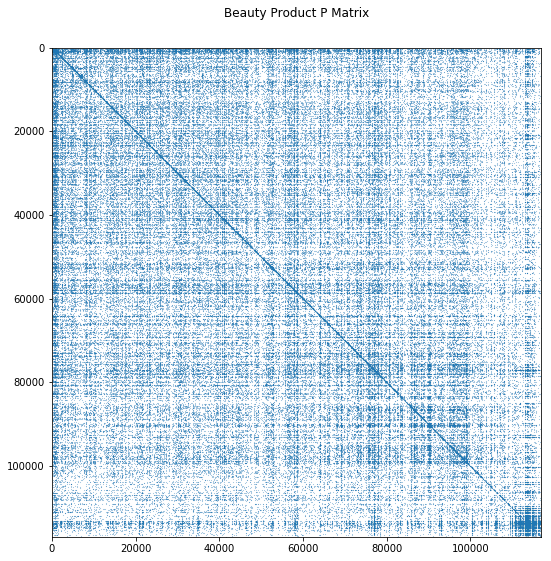

In [86]:
fig, ax = plt.subplots(figsize=(9, 9))
ax.spy(B_bag_P[2014], ms=0.1)
ax.xaxis.tick_bottom()
plt.title('Beauty Product P Matrix')
plt.show()

#### Plot product-level Q matrix

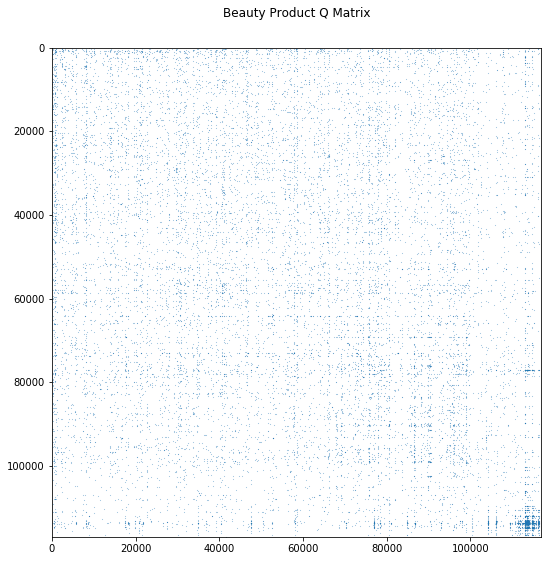

In [87]:
fig, ax = plt.subplots(figsize=(9, 9))
ax.spy(B_bag_Q[2014], ms=0.1)
ax.xaxis.tick_bottom()
plt.title('Beauty Product Q Matrix')
plt.show()

#### Plot product-level R matrix

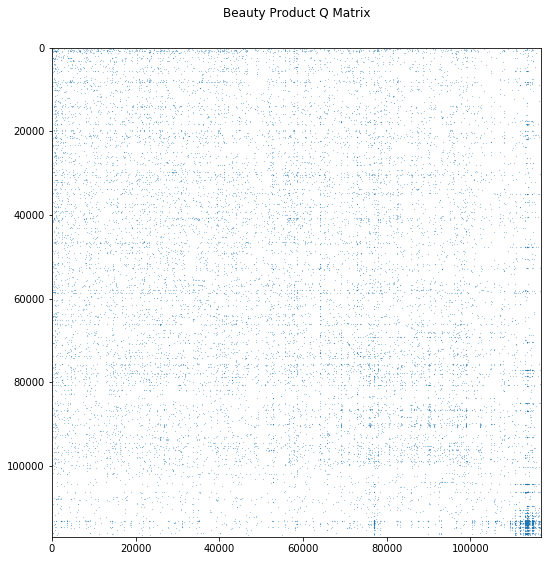

In [88]:
fig, ax = plt.subplots(figsize=(9, 9))
ax.spy(B_bag_R[2014], ms=0.1)
ax.xaxis.tick_bottom()
plt.title('Beauty Product Q Matrix')
plt.show()

### Define function to Build Brand PQR Matrices

In [89]:
def prod2brandPQR(transform, bag_P, bag_Q, bag_R):
    bag_P_brand = {}
    bag_Q_brand = {}
    bag_R_brand = {}
    for y in bag_P.keys():
        bag_P_brand[y] = transform.transpose().dot(bag_P[y]).dot(transform)
        bag_Q_brand[y] = transform.transpose().dot(bag_Q[y]).dot(transform)
        bag_R_brand[y] = transform.transpose().dot(bag_R[y]).dot(transform)
        
    return bag_P_brand, bag_Q_brand, bag_R_brand

#### Calculate BRAND-LEVEL PQR Matrices for all 3 product groups

In [90]:
B_bag_P_brand, B_bag_Q_brand, B_bag_R_brand = prod2brandPQR(B_Transform, B_bag_P, B_bag_Q, B_bag_R)
C_bag_P_brand, C_bag_Q_brand, C_bag_R_brand = prod2brandPQR(C_Transform, C_bag_P, C_bag_Q, C_bag_R)
E_bag_P_brand, E_bag_Q_brand, E_bag_R_brand = prod2brandPQR(E_Transform, E_bag_P, E_bag_Q, E_bag_R)

#### Plot brand-level P matrix

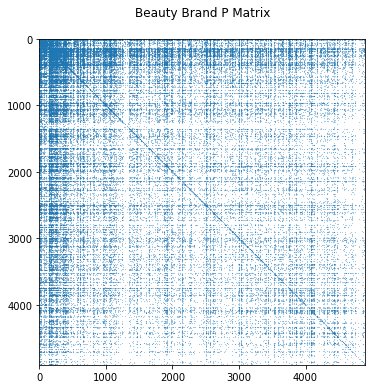

In [91]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.spy(B_bag_P_brand[2014], ms=0.1)
ax.xaxis.tick_bottom()
plt.title('Beauty Brand P Matrix')
plt.show()

#### Plot brand-level Q matrix

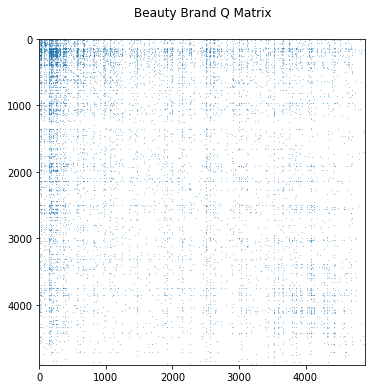

In [92]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.spy(B_bag_Q_brand[2014], ms=0.1)
ax.xaxis.tick_bottom()
plt.title('Beauty Brand Q Matrix')
plt.show()

#### Plot brand-level R matrix

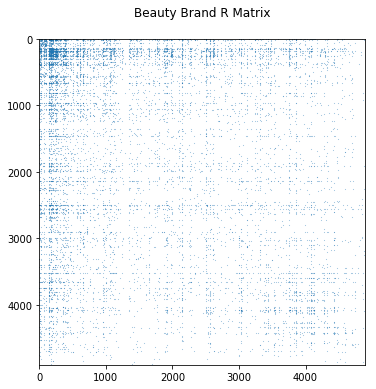

In [93]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.spy(B_bag_R_brand[2014], ms=0.1)
ax.xaxis.tick_bottom()
plt.title('Beauty Brand R Matrix')
plt.show()

#### Define function to save/load BRAND-LEVEL pickle files for PQR

In [94]:
def save_PQRpickle(P, Q, R, tag):
    path = os.getcwd() + r'\pickle\\'
    pickle.dump(P, open(path + tag + '_bag_P_brand.pkl', "wb" ))
    pickle.dump(Q, open(path + tag + '_bag_Q_brand.pkl', "wb" ))
    pickle.dump(R, open(path + tag + '_bag_R_brand.pkl', "wb" ))

def load_PQRpickle(tag):
    path = os.getcwd() + r'\pickle\\'
    return pickle.load(open(path + tag + '_bag_P_brand.pkl', "rb" )), \
           pickle.load(open(path + tag + '_bag_Q_brand.pkl', "rb" )), \
           pickle.load(open(path + tag + '_bag_R_brand.pkl', "rb" ))

### Save BRAND-LEVEL PQR Matrices for all product types

In [95]:
save_PQRpickle(B_bag_P_brand, B_bag_Q_brand, B_bag_R_brand, 'B')
save_PQRpickle(C_bag_P_brand, C_bag_Q_brand, C_bag_R_brand, 'C')
save_PQRpickle(E_bag_P_brand, E_bag_Q_brand, E_bag_R_brand, 'E')